In [138]:
# For Data Manipulation
import numpy as np
import pandas as pd
import pickle

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# For ML Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , PowerTransformer , PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score , mean_squared_error

# For ML Algorithms
from sklearn.linear_model import LinearRegression , Ridge , Lasso , ElasticNet
from sklearn.linear_model import SGDRegressor

In [139]:
ad = pd.read_csv(r"C:\Users\iaman\ML\MACHINE LEARNING PROJECTS\Datasets\advertising.csv")

In [140]:
ad.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [141]:
print(f"Checking the Missing Value : {ad.isna().sum().sum()}")
print(f"Checking the Duplicated Value : {ad.duplicated().sum()}")

Checking the Missing Value : 0
Checking the Duplicated Value : 0


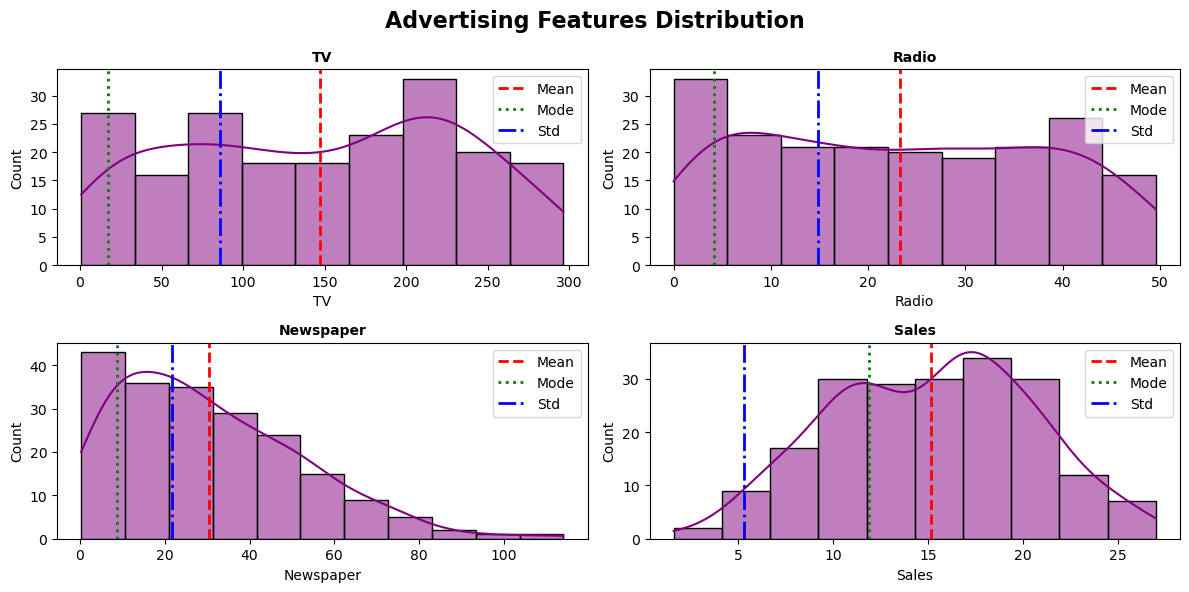

In [142]:
features = ['TV' , 'Radio' , 'Newspaper' , 'Sales']

fig , ax = plt.subplots( 2 , 2 , figsize = ( 12 , 6 ) )
ax = ax.flatten()

for i , feature in enumerate(features):

    mean = ad[feature].mean()
    std = ad[feature].std()
    mode = ad[feature].mode()[0]
        
    sns.histplot(ad[feature], kde=True, ax=ax[i] , color = 'purple')
    ax[i].axvline(mean , color='red', linestyle='dashed', linewidth=2, label='Mean')
    ax[i].axvline(mode , color='green', linestyle='dotted', linewidth=2, label='Mode')
    ax[i].axvline(std , color='blue', linestyle='dashdot', linewidth=2, label='Std')
    ax[i].set_title(f"{feature}" , fontsize = 10 , fontweight = 'bold')
    ax[i].legend()

plt.suptitle("Advertising Features Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

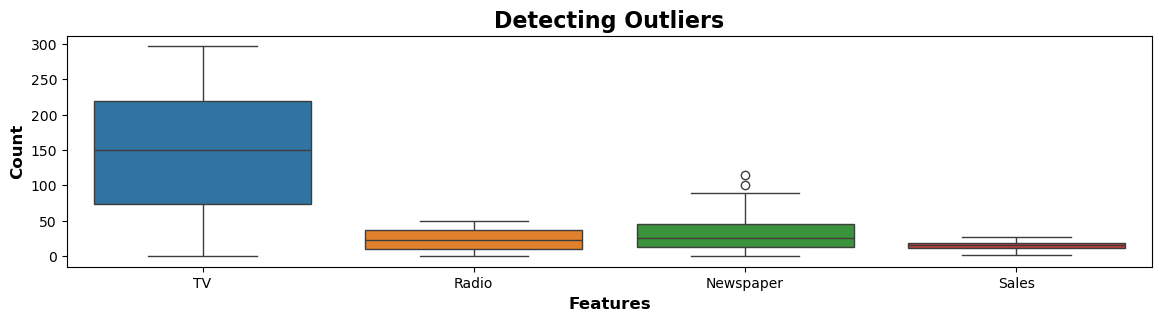

In [144]:
plt.figure( figsize = (14 , 3) )
sns.boxplot(ad)
plt.title( 'Detecting Outliers' , fontsize = 16 , fontweight = 'bold' )
plt.xlabel( 'Features', fontsize = 12 , fontweight = 'bold' )
plt.ylabel( 'Count', fontsize = 12 , fontweight = 'bold' )
plt.show()

In [145]:
num_pipeline = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

In [146]:
X = ad.drop( columns = 'Sales' )
y = ad['Sales']

X_train , X_test , y_train , y_test = train_test_split( X , y , test_size = 0.2 , random_state = 42 )

In [147]:
Regressors = {
    'Linear Regression' : LinearRegression(),
    'SGDRegressor' : SGDRegressor(),
    'Ridge' : Ridge( alpha = 0.1 ),
    'Lasso' : Lasso( alpha = 0.01 ),
    'ElasticNet' : ElasticNet( alpha = 0.1  , l1_ratio = 0.9 )
}

In [159]:
best_model = None
best_score = -np.inf
best_name = ""

for name, Regressor in Regressors.items():

    print("\n" + "="*50)
    print(f"\t\tTraining {name}")
    print("="*50)
    
    model = Pipeline([
        ('num_pipeline', num_pipeline),
        ('regressor', Regressor)
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"R² Score  : {r2:.4f}")
    print(f"MSE      : {mse:.4f}")
    print(f"RMSE     : {rmse:.4f}")

    newspaper_fixed = X_train["Newspaper"].mean()

    tv_range = np.linspace(X_train["TV"].min(), X_train["TV"].max(), 40)
    radio_range = np.linspace(X_train["Radio"].min(), X_train["Radio"].max(), 40)
    
    tv_grid, radio_grid = np.meshgrid(tv_range, radio_range)

    grid_points = pd.DataFrame({
        "TV": tv_grid.ravel(),
        "Radio": radio_grid.ravel(),
        "Newspaper": np.full(tv_grid.size, newspaper_fixed)
    })
    z_pred = model.predict(grid_points)
    z_pred = z_pred.reshape(tv_grid.shape)

    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter3d(
        x = ad["TV"],
        y = ad["Radio"],
        z = ad["Sales"],
        mode = "markers",
        marker = dict(size=4),
        name = "Actual Data"
    ))
    
    fig.add_trace(go.Surface(
        x = tv_grid,
        y = radio_grid,
        z = z_pred,
        opacity = 0.7,
        name = "Regression Hyperplane"
    ))
    
    fig.update_layout(
        title = f"{name} Regression Hyperplane (Newspaper fixed at {newspaper_fixed:.2f})",
        width=1150,  
        height=500,
        scene = dict(
            xaxis_title="TV",
            yaxis_title="Radio",
            zaxis_title="Sales"
        )
    )
    
    fig.show()
    
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_name = name

    with open("best_add_model.pkl", "wb") as file:
        pickle.dump(best_model, file)

print(f"\nBest Model Saved: {best_name}")
print(f"Best R² Score   : {best_score:.4f}")


		Training Linear Regression
R² Score  : 0.9463
MSE      : 1.6607
RMSE     : 1.2887



		Training SGDRegressor
R² Score  : 0.9472
MSE      : 1.6320
RMSE     : 1.2775



		Training Ridge
R² Score  : 0.9463
MSE      : 1.6589
RMSE     : 1.2880



		Training Lasso
R² Score  : 0.9469
MSE      : 1.6401
RMSE     : 1.2807



		Training ElasticNet
R² Score  : 0.9445
MSE      : 1.7141
RMSE     : 1.3092



Best Model Saved: SGDRegressor
Best R² Score   : 0.9472
